In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. 데이터 불러오기
df = pd.read_csv("./UNSW_NB15_testing-set.csv")

# 2. 필요한 공격 유형만 필터링
target_cats = ["Backdoors", "Exploits", "Generic", "Reconnaissance","Normal"]
df = df[df["attack_cat"].isin(target_cats)]
print("데이터 개수:", len(df))



데이터 개수: 139884


In [4]:
df.dtypes

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

In [15]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [28]:
# 3. 입력(X), 타겟(y) 분리
X = df.drop(columns=["label", "attack_cat","id","stcpb","dtcpb"])  # label은 정상/공격, attack_cat은 세부 공격유형
y = df["label"]

# 4. 범주형 컬럼 인코딩
categorical_cols = X.select_dtypes(include=["object"]).columns
print("범주형 컬럼:", categorical_cols.tolist())

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # 나중에 pickle로 저장
# 5. 수치형 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. 데이터 분할 (train/test = 8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42, stratify=y
)

# 7. 모델 학습 (랜덤포레스트)
clf = RandomForestClassifier(max_depth= 15,max_features= 'sqrt',min_samples_leaf= 2, min_samples_split= 5,
                             n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# 8. 예측 및 평가
y_pred = clf.predict(X_test)

print("=== 분류 보고서 ===")
print(classification_report(y_test, y_pred))

print("=== 혼동 행렬 ===")
print(confusion_matrix(y_test, y_pred))

# 컬럼 순서 저장
FEATURE_COLS = X.columns.tolist()

# 9. 모델 + LabelEncoder + Scaler를 pickle로 저장
with open("best_clf_password_model.pkl", "wb") as f:
    pickle.dump((clf, le_dict, scaler, FEATURE_COLS), f)

범주형 컬럼: ['proto', 'service', 'state']
=== 분류 보고서 ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5600
           1       0.99      1.00      0.99      8389

    accuracy                           0.99     13989
   macro avg       0.99      0.99      0.99     13989
weighted avg       0.99      0.99      0.99     13989

=== 혼동 행렬 ===
[[5523   77]
 [  38 8351]]


In [29]:
X['proto'].unique()

array([113, 119,   6,  78,  37,  42,  91,  26,  31,  83,  41,  82,   5,
        80,  88,  97,  96,   1,  46, 104,  14,  57,  79,  63, 132,  21,
        35, 109, 107, 121,  71, 103, 110, 111, 102,  85,  29,  59,  17,
        18,  95,  28,  90, 120,  45,  50, 108,   4,   8,  25,  43,  86,
       129,  13,  19,  33,  84, 116, 130,  65,  66,  89,  58,  61,  75,
        67,  68,   0, 100,  38, 131,  39, 115,  44,  52,  98,  56,  53,
        40,  32,  69,  92,  34,  74,  77, 101,  54,  73,  55,  12,   3,
        93,  62, 117,  51,  94, 123,  47,  15,  20,  16, 128,  87,  10,
       127, 126,   9,  60,  99, 124, 118, 122,  76,  22, 112,  24,  64,
        72,   7,  48,   2,  70,  27,  23,  36,  30, 114,  11, 105, 125,
        81,  49, 106])

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [300],           # 트리 개수
    'max_depth': [15],          # 트리 최대 깊이
    'min_samples_split': [5],          # 노드 분할 최소 샘플 수
    'min_samples_leaf': [2],            # 리프 노드 최소 샘플 수
    'max_features': ['sqrt']    # 각 분할에서 고려할 최대 특징 수
}
# 2️⃣ GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                # 5-fold 교차검증
    n_jobs=-1,           # 모든 CPU 코어 사용
    verbose=2,
    scoring='accuracy'   # 평가 기준
)

# 3️⃣ 학습
grid_search.fit(X_train, y_train)

# 4️⃣ 최적 파라미터 확인
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# 5️⃣ 최적 모델로 예측
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# 6️⃣ 평가
print("=== 분류 보고서 ===")
print(classification_report(y_test, y_pred))
print("=== 혼동 행렬 ===")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy:  0.9911150015611445
=== 분류 보고서 ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16800
           1       0.99      0.99      0.99     25166

    accuracy                           0.99     41966
   macro avg       0.99      0.99      0.99     41966
weighted avg       0.99      0.99      0.99     41966

=== 혼동 행렬 ===
[[16556   244]
 [  138 25028]]


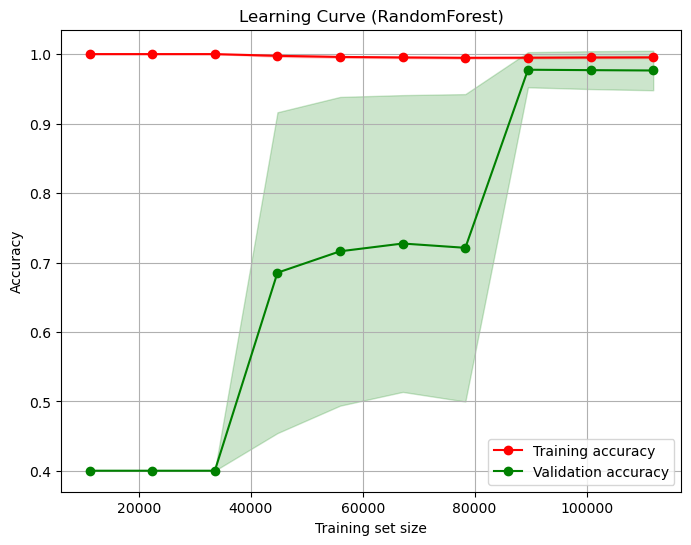

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# 학습 곡선 계산
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_scaled, y, cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 출력
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation accuracy")

# 신뢰 구간 (± 표준편차)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve (RandomForest)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# 학습 곡선 계산
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X_scaled, y, cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 그래프 출력
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation accuracy")

# 신뢰 구간 (± 표준편차)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve (RandomForest)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


NameError: name 'best_clf' is not defined

In [3]:
from flask import Flask, request, jsonify
import pickle
import os
import pandas as pd

app = Flask(__name__)

# 모델과 전처리기 로드
model_path = os.path.join(os.getcwd(), 'best_clf_password_model.pkl')
with open(model_path, 'rb') as f:
    clf, le_dict, scaler, FEATURE_COLS = pickle.load(f)  # 모델, LabelEncoder dict, Scaler, 컬럼 순서

# 범주형 컬럼
categorical_cols = list(le_dict.keys())

@app.route('/detect', methods=['POST'])
def detect():
    data = request.json
    print("Received JSON:", data)

    if not data:
        return jsonify({'error': 'JSON 데이터가 필요합니다'}), 400

    try:
        # DataFrame으로 변환
        df = pd.DataFrame([data])
    except Exception as e:
        return jsonify({'error': f'DataFrame 변환 실패: {str(e)}'}), 400

    # 모든 범주형 컬럼에 LabelEncoder 적용
    for col in categorical_cols:
        if col in df.columns:
            try:
                df[col] = le_dict[col].transform(df[col].astype(str))
            except Exception as e:
                return jsonify({'error': f'LabelEncoder 변환 실패 ({col}): {str(e)}'}), 400
        else:
            return jsonify({'error': f'{col} 컬럼이 누락되었습니다'}), 400

    # 컬럼 순서 맞추기
    missing_cols = set(FEATURE_COLS) - set(df.columns)
    if missing_cols:
        return jsonify({'error': f'누락된 컬럼: {list(missing_cols)}'}), 400
    df = df[FEATURE_COLS]

    # 스케일링 및 예측
    try:
        X_scaled = scaler.transform(df)
        prediction = clf.predict(X_scaled)[0]  # 0 = 정상, 1 = 공격
    except Exception as e:
        return jsonify({'error': f'예측 실패: {str(e)}'}), 500

    return jsonify({'blocked': bool(prediction)})

if __name__ == '__main__':
    app.run(host='localhost', port=5001)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5001
Press CTRL+C to quit
127.0.0.1 - - [15/Sep/2025 13:42:43] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:44:30] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:44:50] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:46:49] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:46:51] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:47:02] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:54:23] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:57:34] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 13:57:48] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:00:56] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:01:19] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:01:52] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:02:37] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:02:42] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:02:53] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:03:07] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:16:54] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:17:03] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:31:12] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:31:22] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:31:34] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:32:02] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:34:35] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:34:39] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:35:16] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:35:19] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:41:21] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:41:28] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:42:41] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:42:45] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:44:05] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:44:07] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:44:22] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:44:59] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:45:08] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:45:23] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'email': 'shin3481@gmail.com', 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'ip': '0:0:0:0:0:0:0:1', 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'device': 'PostmanRuntime/7.46.0', 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:49:57] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:50:03] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:51:26] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 1.1e-05, 'sbytes': 0, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 1, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 0.0, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 0, 'djit': 0, 'spkts': 0, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 64, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 1, 'service': '-', 'ct_srv_dst': 1, 'proto': 'udp', 'sjit': 0, 'dload': 0, 'sinpkt': 0.011, 'response_body_len': 0, 'swin': 0, 'smean': 0, 'ct_dst_sport_ltm': 1}


127.0.0.1 - - [15/Sep/2025 14:51:29] "POST /detect HTTP/1.1" 200 -


Received JSON: {'dur': 0.921987, 'sbytes': 1280, 'dbytes': 0, 'ackdat': 0, 'ct_dst_src_ltm': 2, 'ct_flw_http_mthd': 0, 'sloss': 0, 'trans_depth': 0, 'rate': 20.607666, 'ct_src_dport_ltm': 1, 'is_ftp_login': 0, 'dwin': 0, 'ct_srv_src': 1, 'synack': 0, 'state': 'INT', 'dmean': 0, 'sload': 10551.125, 'djit': 0, 'spkts': 20, 'is_sm_ips_ports': 0, 'dttl': 0, 'tcprtt': 0, 'ct_dst_ltm': 1, 'dpkts': 0, 'sttl': 254, 'dinpkt': 0, 'ct_src_ltm': 1, 'ct_ftp_cmd': 0, 'dloss': 0, 'ct_state_ttl': 2, 'service': '-', 'ct_srv_dst': 1, 'proto': 'ospf', 'sjit': 52.253805, 'dload': 0, 'sinpkt': 48.525633, 'response_body_len': 0, 'swin': 0, 'smean': 64, 'ct_dst_sport_ltm': 1}
